# Simulation of patient length of stays

In this notebook, I describe how I simulated patient lengths of stay for my project at Insight. I simulated this data to serve as both a proof of concept and a benchmark for performance of a predictive model which would take hospital spatial data as an input and an outcome of interest like patient length of stay.

First, I import necessary packages.

In [30]:
#standard
import pandas as pd
import janitor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

#Sampling
from scipy.stats import gamma

And now I read in my file. This file contains spatial data on 10,000 rooms from auto-generated AutoCAD floor plans that I received from Spatio Metrics. It also contains simulated patient outcomes (length of stay, pain medicine) and hospital outcomes (medical errors and complications).

In [7]:
data_fn = 'Data/190508_Output.csv'
df = pd.read_csv(data_fn)
df.head()

,viewType,roomDepth,distToElevator,distToNurseStation,roomArea,lengthOfStay,painMedicine,medError,complicationRate,imgPath,roomCoordinateX,roomCoordinateY,headIsovist,doorIsovist,sinkIsovist,isGreenery,isBuilding,isParking,NA,NA.1
0,hardscape,0.294253,236.617906,110.440005,450,5.154973,29.046473,0,0,0,-11.741383,99.007585,426.676555,480.776509,336.318056,0,1,0,0,0
1,building,0.464286,99.592921,19.918584,450,2.994674,12.641982,0,0,1,78.718213,-0.278939,548.296155,636.071360,374.817764,0,1,0,0,0
2,greenery,0.257143,153.002567,67.301283,450,4.084376,11.470255,0,0,2,75.563544,-60.183228,436.017976,493.723516,343.912753,1,0,0,0,0
3,greenery,0.300265,201.873097,119.523355,450,2.174077,7.381344,0,0,3,-19.022660,79.790069,445.453332,498.349012,347.664951,1,0,0,0,0
4,hardscape,0.301149,220.303850,122.501283,450,5.513778,32.983419,0,0,4,-76.602378,58.855296,436.017976,493.723516,343.912753,0,1,0,0,0


In [20]:
df.shape

(10001, 20)

Based on some EDA and early modeling I did, I decided to simulate patient outcome based off of parameters from literature. I decided to simulate length of stay, so I dropped everything in the data frame that wasn't room spatial features. I also changed titles to `snake_case`.

In [8]:
#Generate cleaned data
clean_df = (
    df
    .clean_names(case_type='snake')
    .drop(columns=['is_greenery', 'is_building', 
                   'is_parking', 'na', 'na_1',
                  'room_coordinate_x', 'room_coordinate_y',
                  'img_path', 'room_area', 'length_of_stay',
                  'pain_medicine', 'med_error', 
                   'complication_rate'])
    .encode_categorical('view_type')
)
clean_df.head()

,view_type,room_depth,dist_to_elevator,dist_to_nurse_station,head_isovist,door_isovist,sink_isovist
0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056
1,building,0.464286,99.592921,19.918584,548.296155,636.071360,374.817764
2,greenery,0.257143,153.002567,67.301283,436.017976,493.723516,343.912753
3,greenery,0.300265,201.873097,119.523355,445.453332,498.349012,347.664951
4,hardscape,0.301149,220.303850,122.501283,436.017976,493.723516,343.912753


I chose to simulate length of stay (LOS) because it was the outcome which I found the most data for related to the spatial features in this data set. Additionally, it is a critical health outcome, as it impacts patient costs, hospital room turnover, and increases risk of hospital acquired infections. For this study, I decided to simulate 80 patient stays per room, which is roughly a year's worth of stays based off of an average length of stay of [4.5 days](https://www.ncbi.nlm.nih.gov/books/NBK259100/). 

In [10]:
repeat_index = np.repeat(np.arange(len(clean_df)), 80)
clean_df_full = clean_df.iloc[repeat_index].reset_index()
mean_LOS = 4.5

In [21]:
clean_df_full.shape[0]

800080

LOS is roughly [gamma distributed](https://www.tandfonline.com/doi/abs/10.1080/00949655.2017.1300904). If I had the mean for each room, I could simulate a patient stay in that room by sampling from a gamma distribution with that mean. To find a mean LOS for each room, I found parameters which impact patient mean length of stay: view from the window, delirium, and patient falls.

![params](Images/simulation_parameters.png "Simulation Parameters")

Source hyperlinks: 1) [Ulrich](https://science.sciencemag.org/content/224/4647/420.long), 2) [Dunne et al.](https://onlinelibrary.wiley.com/doi/abs/10.1111/jep.12144), and 3) [Mangusan et al.](http://ajcc.aacnjournals.org/content/24/2/156.full)

In order to incorporate the value changes from patient falls and delirium, I had to first simulate whether or not a patient experienced either of these events with input from spatial parameters in my dataset. Let's start with falls.

### Simulating hospital falls

I found that the average incidence of a hospital fall is [3-5 per 1000 patient days](https://www.memorialcare.org/sites/default/files/media/Pat%20Quigley%20Falls%20and%20Fall-related%20injuries%20in%20hospitals%20-%20D%20Oliver%20May%202014.pdf). I also found that proximity to the nurse station can [reduce risk of fall up to 75% along with other factors](https://www.healthdesign.org/sites/default/files/fall_risks_report_final.pdf/). I used these values to create conditional probabilities of falls in rooms based on whether or not there was a nurse station within 60 feet, and used random number generation to simulate falls for each patient.

In [18]:
#declaring fall probs, second line is transforming to 
falls_per_1000_patient_days = 4
falls_per_patient = falls_per_1000_patient_days / 1000 * mean_LOS
falls_with_nurse_close = falls_per_patient * (1 - 0.5)

#making filter for nurse station
close_nurse_station = clean_df_full.dist_to_nurse_station < 60

#adding probs based of nurse station
fall_prob_feature = ((falls_per_patient * ~close_nurse_station)
                         + (falls_with_nurse_close * close_nurse_station))
clean_df_full = clean_df_full.add_column('fall_prob', fall_prob_feature)

# fall simulation
np.random.seed(123)
random_nums_fall = np.random.rand(clean_df_full.shape[0])
fall = random_nums_fall < fall_prob_feature
clean_df_full = clean_df_full.add_column('fall', fall.astype('int'))

In [19]:
clean_df_full.head()

,index,view_type,room_depth,dist_to_elevator,dist_to_nurse_station,head_isovist,door_isovist,sink_isovist,fall_prob,fall
0,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0
1,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0
2,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0
3,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0
4,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0


Now I have whether or not a fall happened for each patient!

### Simulating delirium

I found that [3–29% of patients acquire delirium while in the hospital](https://academic.oup.com/ageing/article/35/4/350/21998). I also found that delirium has a [much higher incidence in sleep-deprived patients](https://europepmc.org/abstract/med/1177486), and made the assumption that proximity to the elevator could influence sleep. I used these values and this knowledge to create conditional probabilities of delirium based off of distance to the elevator, which could influence the traffic and therefore the amount of noise that patients could be subjected to in their room that could interprut their sleep.

In [24]:
#declaring delirium probs
wake_risk_very_close = 0.22
wake_risk_close = wake_risk_very_close * 0.8
baseline = 0.22 * 0.6

#making filter for elevator values
very_close_filter = clean_df_full.dist_to_elevator < 50
close_filter = (clean_df_full.dist_to_elevator >= 50) & (clean_df_full.dist_to_elevator < 100)
far_filter = clean_df_full.dist_to_elevator >= 100

#adding probs based off of elevator
delirium_prob_feature = ((wake_risk_very_close * very_close_filter)
                         + (wake_risk_close * close_filter)
                         + (baseline * far_filter))                   
clean_df_full = clean_df_full.add_column('delirium_prob', delirium_prob_feature)

# delirium simulation
np.random.seed(42)
random_nums_delirium = np.random.rand(clean_df_full.shape[0])
has_delirium = random_nums_delirium < delirium_prob_feature
clean_df_full = clean_df_full.add_column('has_delirium', has_delirium.astype('int'))

Now we have whether or not delirium occured for each patient.

### Calculating mean length of stays per patient

Now that I have whether delirium and a fall occured for each patient, I could simulate a length of stay for each patient by sampling from a gamma distribution off of their own estimated, personal mean LOS. To do this, I first needed to adjuste each patient's mean LOS based off of whether they had a view from nature, if they fell, and if they experienced delirium.

In [25]:
# contribution of trees
tree_average = 7.96
no_tree_average = 8.7
tree_exp_mean = (tree_average + no_tree_average) / 2
tree_diff = tree_average - tree_exp_mean 
no_tree_diff = no_tree_average - tree_exp_mean
weighted_greenery_modifier = tree_diff * (mean_LOS / tree_exp_mean)
weighted_no_greenery_modifier = no_tree_diff * (mean_LOS / tree_exp_mean)
#arrays for trees
greenery_modifier_array = ((clean_df_full.view_type=='greenery')*weighted_greenery_modifier
                           + ~(clean_df_full.view_type=='greenery')*weighted_no_greenery_modifier)

# contribution of fall
fall_average = 37.2
no_fall_average = 25.7
fall_study_mean = (292/622) * 37.2 + (330/622) * 25.7

fall_modifier = ((fall_average - fall_study_mean) / fall_study_mean) * mean_LOS
no_fall_modifier = ((no_fall_average - fall_study_mean) / fall_study_mean) * mean_LOS

fall_modifier_array = ((clean_df_full.fall==1) * fall_modifier
                       + (clean_df_full.fall==0) * no_fall_modifier)


#contribution of delirium
del_study_mean_LOS = 6.2
del_pos_LOS = 8.3
del_neg_LOS = 5.5

delirium_modifier = (del_pos_LOS - del_study_mean_LOS) / del_study_mean_LOS * mean_LOS
no_delirium_modifier = (del_neg_LOS - del_study_mean_LOS) / del_study_mean_LOS * mean_LOS

delirium_modifier_array = ((clean_df_full.has_delirium==1) * delirium_modifier
                           + (clean_df_full.has_delirium==0) * no_delirium_modifier)

#creating the mean LOS per patient 
mean_per_patient = (
    mean_LOS  
    + greenery_modifier_array
    + fall_modifier_array
    + delirium_modifier_array
)
#adding it to our array
clean_df_full = clean_df_full.add_column('summed_mean', mean_per_patient)

In [26]:
clean_df_full.head()

,index,view_type,room_depth,dist_to_elevator,dist_to_nurse_station,head_isovist,door_isovist,sink_isovist,fall_prob,fall,delirium_prob,has_delirium,summed_mean
0,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
1,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
2,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
3,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
4,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619


### Simulating length of stays

Now that I have expected means for each patient, I can simulate from a gamma distribution. Here's the function I used:

In [27]:
#sampling from gamma distribution
def sample_gamma(mean, variance, random_state):
    scale = variance / mean
    shape = mean / scale
    return gamma.rvs(shape, scale=scale, size=1, random_state=random_state)

And here's the code I used to add the values. I chose to use variance = mean, which is [a slight overestimate to the actual variance](https://www.tandfonline.com/doi/abs/10.1080/00949655.2017.1300904). **Warning** this code takes ~5 minutes to execute since we need to generate a random number each row which is different than the random number from each other row.

In [31]:
#variance for scale factor 1
variance = 4.5
#making sampled mean
sampled_mean = (np.vectorize(sample_gamma)
            (clean_df_full.summed_mean, variance, np.arange(features_df_full.shape[0])))

Let's add it to our data frame

In [32]:
clean_df_full = clean_df_full.add_column('sampled_LOS', sampled_mean)

### Visualizing simulated data

I wanted to see how my simulated patient LOS depended on my input spatial features.

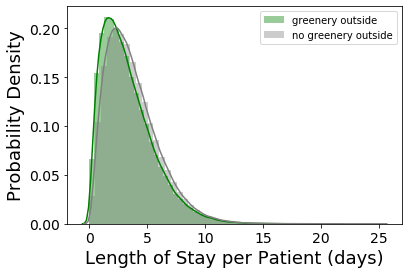

In [38]:
# visualizing LOS by view
sns.distplot(clean_df_full.filter_on('view_type=="greenery"').loc[:, 'sampled_LOS'], 
             color='green', label='greenery outside')
ax = sns.distplot(clean_df_full.filter_on('view_type!="greenery"').loc[:, 'sampled_LOS'], 
                  color='grey', label='no greenery outside')
plt.xlabel('Length of Stay per Patient (days)', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend()
ax.tick_params(axis='both', which='major', labelsize=14)

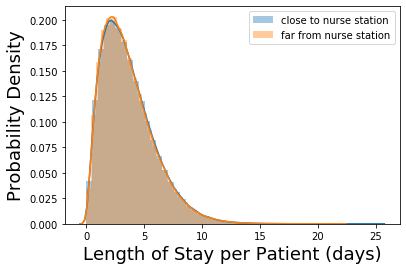

In [39]:
# visualizing LOS by nurse station distance
sns.distplot(clean_df_full.filter_on('dist_to_nurse_station<60').loc[:, 'sampled_LOS'],
            label='close to nurse station')
sns.distplot(clean_df_full.filter_on('dist_to_nurse_station>60').loc[:, 'sampled_LOS'],
            label='far from nurse station')
plt.xlabel('Length of Stay per Patient (days)', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend()
ax.tick_params(axis='both', which='major', labelsize=12)

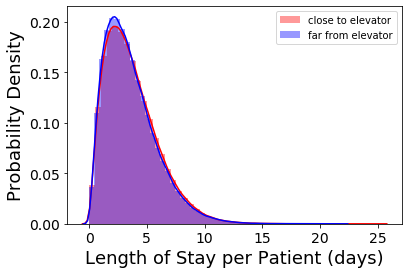

In [40]:
# visualizing LOS by elevator distance
sns.distplot(clean_df_full.filter_on('dist_to_elevator<100').loc[:, 'sampled_LOS'], 
             color='red', label='close to elevator')
ax = sns.distplot(clean_df_full.filter_on('dist_to_elevator>100').loc[:, 'sampled_LOS'], 
                  color='blue', label='far from elevator')
plt.xlabel('Length of Stay per Patient (days)', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend()
ax.tick_params(axis='both', which='major', labelsize=14)

There is a whole lot of overlap. Although some predictive models might be able to see these slight slight differences, it will likely be easier to see at the level of the room. I'm going to aggregate LOS by room now.

### Visualizing distributions of room-aggregated LOS

In [42]:
#aggregating features by room
aggregated_features = clean_df_full.groupby('index').mean()

#adding view type back in
agg_features_view = (
    aggregated_features
    .add_column('view_type', clean_df.view_type)
)

agg_features_view.head()

,room_depth,dist_to_elevator,dist_to_nurse_station,head_isovist,door_isovist,sink_isovist,fall_prob,fall,delirium_prob,has_delirium,summed_mean,sampled_LOS,view_type
index,,,,,,,,,,,,,
0,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0.0125,0.132,0.1625,3.761661,3.665700,hardscape
1,0.464286,99.592921,19.918584,548.296155,636.071360,374.817764,0.009,0.0125,0.176,0.1625,3.761661,3.795298,building
2,0.257143,153.002567,67.301283,436.017976,493.723516,343.912753,0.018,0.0125,0.132,0.1375,3.311095,3.370062,greenery
3,0.300265,201.873097,119.523355,445.453332,498.349012,347.664951,0.018,0.0625,0.132,0.1375,3.394298,3.473077,greenery
4,0.301149,220.303850,122.501283,436.017976,493.723516,343.912753,0.018,0.0250,0.132,0.1875,3.833269,3.585154,hardscape


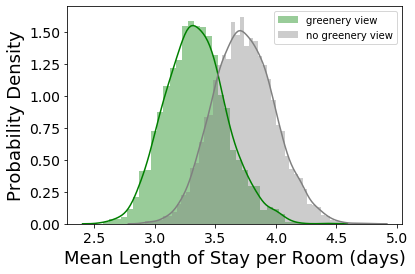

In [43]:
#Visualizing mean LOS by view
sns.distplot(agg_features_view.filter_on('view_type=="greenery"').loc[:, 'sampled_LOS'], 
             color='green', label='greenery view')
ax = sns.distplot(agg_features_view.filter_on('view_type!="greenery"').loc[:, 'sampled_LOS'], 
                  color='grey', label='no greenery view')
plt.xlabel('Mean Length of Stay per Room (days)', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend()
ax.tick_params(axis='both', which='major', labelsize=14)

Much more separation! Let's look at the other parameters.

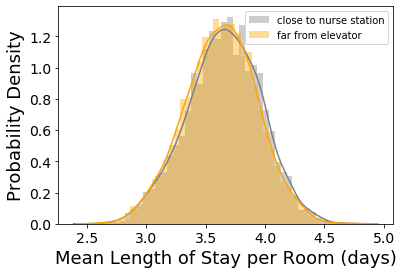

In [45]:
#Visualizing mean LOS by nurse station distance
sns.distplot(agg_features_view.filter_on('dist_to_nurse_station<60').loc[:, 'sampled_LOS'], 
             color='grey', label='close to nurse station')
ax = sns.distplot(agg_features_view.filter_on('dist_to_nurse_station>60').loc[:, 'sampled_LOS'], 
                  color='orange', label='far from elevator')
plt.xlabel('Mean Length of Stay per Room (days)', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend()
ax.tick_params(axis='both', which='major', labelsize=14)

Still very little separation here - the infrequency of falls likely contributes to not seeing any difference.

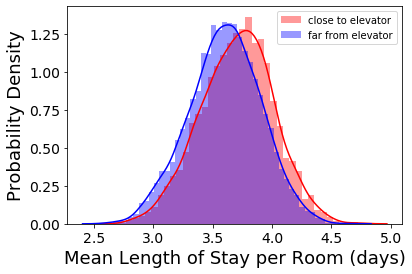

In [44]:
#Visualizing mean LOS by elevator
sns.distplot(agg_features_view.filter_on('dist_to_elevator<100').loc[:, 'sampled_LOS'], 
             color='red', label='close to elevator')
ax = sns.distplot(agg_features_view.filter_on('dist_to_elevator>100').loc[:, 'sampled_LOS'], 
                  color='blue', label='far from elevator')
plt.xlabel('Mean Length of Stay per Room (days)', fontsize=18)
plt.ylabel('Probability Density', fontsize=18)
plt.legend()
ax.tick_params(axis='both', which='major', labelsize=14)

There is a little separation here - it looks like we can better parse contribution of delirium because it is a little more common than falling.

# Summary and exporting data

I simulated patient length of stay day data for: 10,000 rooms and 80 patients per room to represent a years worth of data. I used parameters from literature to simulate realistic differences in length of stay based off of differences in room spatial data. I've found that aggregating patient data by room will likely aid Spatio Metrics in identifying relationships between design features and room-based patient outcomes.

In [46]:
clean_df_full.to_csv('Data/full_simulated_outcomes.csv')

In [47]:
agg_features_view.to_csv('Data/aggregated_simulated_outcomes.csv')